In [ ]:
!pip uninstall -y -q transformers tokenizers datasets accelerate huggingface_hub protobuf numpy
!pip install -q \
  "protobuf<5.0.0" \
  "transformers==4.44.2" \
  "datasets==2.20.0" \
  "accelerate==0.34.2" \
  "tokenizers>=0.19.1" \
  "huggingface_hub>=0.24" \
  "safetensors>=0.4" \
  "sentencepiece>=0.1.99" \
  "numpy==1.26.4"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.

In [ ]:
import transformers, datasets, accelerate, google.protobuf as gp, sys
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("accelerate:", accelerate.__version__)
print("protobuf:", gp.__version__)
print("transformers module path:", transformers.__file__)

from transformers import TrainingArguments, IntervalStrategy
ta_sig = TrainingArguments.__init__.__code__.co_varnames
print("has evaluation_strategy:", "evaluation_strategy" in ta_sig)


transformers: 4.44.2
datasets: 2.20.0
accelerate: 0.34.2
protobuf: 4.25.8
transformers module path: /usr/local/lib/python3.12/dist-packages/transformers/__init__.py
has evaluation_strategy: True


In [2]:
import torch, platform, sys
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Python: 3.12.12
Torch: 2.8.0+cu126 | CUDA available: True
GPU: Tesla T4


In [ ]:
import os, json, re, urllib.request, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
)

from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

warnings.filterwarnings("ignore")
sns.set_theme()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
if torch.cuda.is_available():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

USE_BF16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
USE_FP16 = torch.cuda.is_available() and not USE_BF16
print({"USE_BF16": USE_BF16, "USE_FP16": USE_FP16})


{'USE_BF16': False, 'USE_FP16': True}


English rows: 11491
Sentiment
neutral      8877
positive     1686
negative      928
Name: count, dtype: int64


,PostID,Post Description,Date,Language Code,Full Language,Sentiment
11,B7pdhiZJTpC,"Hi sobat sehat, akhir2 ini berita tentang viru...",01/23/2020,id,Indonesian,negative
23,B7wcf50BsQh,Waspada kemunculan Virus Corona yang berasal d...,01/25/2020,id,Indonesian,negative
86,B71CDY_H-g2,.\n.\nVirus corona atau Novel Coronavirus (201...,01/27/2020,id,Indonesian,negative


Classes: {'negative': 0, 'neutral': 1, 'positive': 2}


,text_clean,label
11,"Hi sobat sehat, akhir2 berita virus corona jen...",0
23,Waspada kemunculan Virus Corona berasal Kota W...,0
86,. . Virus corona Novel Coronavirus (2019-nCoV)...,0


Train size: 8618  Test size: 2873


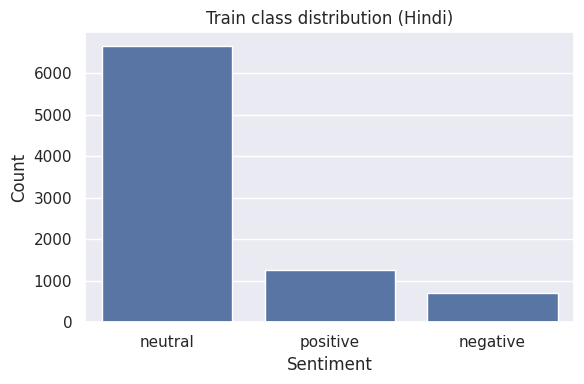

In [ ]:
df = pd.read_csv("covid_instagram.csv")

df = df[(df["Language Code"].astype(str).str.lower()=="id") |
        (df["Full Language"].astype(str).str.lower()=="indonesian")].copy()

text_col = "Post Description"
label_col = "Sentiment"

df = df.dropna(subset=[text_col, label_col])
df = df[df[text_col].astype(str).str.strip().str.len() > 0].copy()
print("Indonesian rows:", len(df))
print(df[[label_col]].value_counts().rename("count"))
display(df.head(3))

STOPWORDS_URL = "https://raw.githubusercontent.com/stopwords-iso/stopwords-id/master/stopwords-id.txt"
STOPWORDS_PATH = "/content/stopwords_id.txt"
if not os.path.exists(STOPWORDS_PATH):
    urllib.request.urlretrieve(STOPWORDS_URL, STOPWORDS_PATH)

with open(STOPWORDS_PATH, "r", encoding="utf-8") as f:
    EN_STOPWORDS = set(w.strip() for w in f if w.strip())

URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
HTML_RE = re.compile(r"&\w+;")
MULTISPACE_RE = re.compile(r"\s+")

def basic_clean(text: str) -> str:
    t = text if isinstance(text, str) else ""
    t = URL_RE.sub(" ", t)
    t = MENTION_RE.sub(" ", t)
    t = HTML_RE.sub(" ", t)
    t = HASHTAG_RE.sub(r"\1", t)
    t = MULTISPACE_RE.sub(" ", t)
    return t.strip()

def remove_stopwords(text: str, stopwords: set) -> str:
    toks = text.split()
    return " ".join(tok for tok in toks if tok.lower() not in stopwords)

df["text_clean"] = df[text_col].astype(str).apply(basic_clean)
df["text_clean"] = df["text_clean"].apply(lambda s: remove_stopwords(s, EN_STOPWORDS))

label_names = sorted(df[label_col].astype(str).str.lower().unique().tolist())
label2id = {lbl:i for i,lbl in enumerate(label_names)}
id2label = {i:lbl for lbl,i in label2id.items()}
df["label"] = df[label_col].astype(str).str.lower().map(label2id)

print("Classes:", label2id)
display(df[["text_clean","label"]].head(3))

train_df, test_df = train_test_split(
    df[["text_clean", "label"]],
    test_size=0.25,
    random_state=SEED,
    stratify=df["label"]
)

print("Train size:", len(train_df), " Test size:", len(test_df))

plt.figure(figsize=(6,4))
sns.countplot(x=train_df["label"].map(id2label))
plt.title("Train class distribution (Hindi)")
plt.xlabel("Sentiment"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


In [ ]:
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["text_clean"],
        truncation=True,
        padding=False,
        max_length=256
    )

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))
raw = DatasetDict({"train": train_ds, "test": test_ds})

tok = raw.map(tokenize_batch, batched=True, remove_columns=["text_clean"])
tok = tok.rename_column("label", "labels")
tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {"accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1}

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/8618 [00:00<?, ? examples/s]

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.486200,0.396750,0.876784,0.841314,0.684790,0.727080
2,0.259100,0.420301,0.894883,0.793622,0.794146,0.793841
3,0.171500,0.426513,0.898364,0.798409,0.802627,0.799240


{
  "eval_loss": 0.42651307582855225,
  "eval_accuracy": 0.8983640793595544,
  "eval_precision_macro": 0.79840905488793,
  "eval_recall_macro": 0.8026266937770669,
  "eval_f1_macro": 0.799239787172619,
  "eval_runtime": 13.6713,
  "eval_samples_per_second": 210.148,
  "eval_steps_per_second": 13.166,
  "epoch": 3.0
}
              precision    recall  f1-score   support

    negative       0.69      0.62      0.65       232
     neutral       0.95      0.94      0.94      2219
    positive       0.76      0.85      0.80       422

    accuracy                           0.90      2873
   macro avg       0.80      0.80      0.80      2873
weighted avg       0.90      0.90      0.90      2873



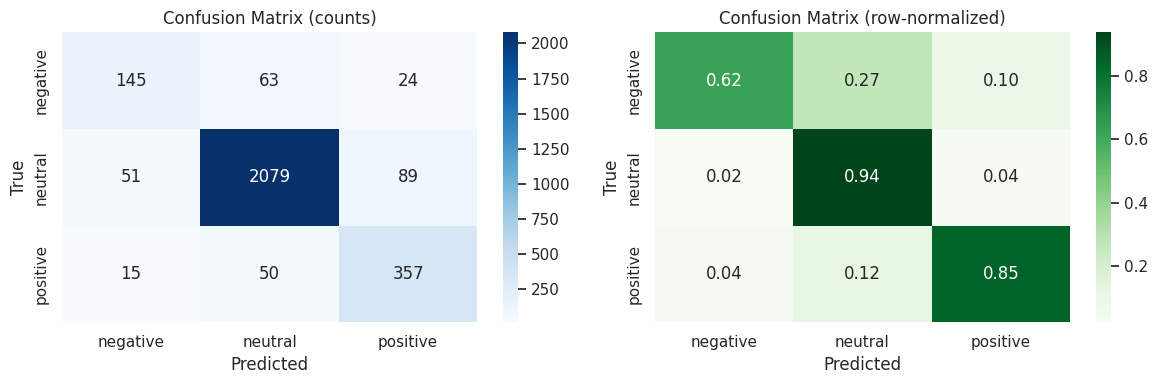

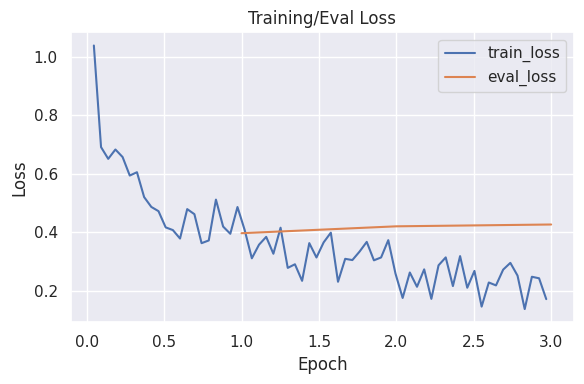

Saved to: /content/xlmr_id_sentiment_best


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {"accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1}

OUTPUT_DIR = "/content/xlmr_id_sentiment"

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",
    fp16=USE_FP16,
    bf16=USE_BF16,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok["train"],
    eval_dataset=tok["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

eval_res = trainer.evaluate()
print(json.dumps(eval_res, indent=2))

preds = trainer.predict(tok["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)]))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)])
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens", ax=ax[1],
            xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)])
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
plt.tight_layout(); plt.show()

logs = trainer.state.log_history
loss_pts = [(e.get("epoch"), e.get("loss")) for e in logs if "loss" in e]
eval_pts = [(e.get("epoch"), e.get("eval_loss")) for e in logs if "eval_loss" in e]

plt.figure(figsize=(6,4))
if loss_pts:
    xs, ys = zip(*loss_pts); plt.plot(xs, ys, label="train_loss")
if eval_pts:
    xs2, ys2 = zip(*eval_pts); plt.plot(xs2, ys2, label="eval_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training/Eval Loss")
plt.legend(); plt.tight_layout(); plt.show()

save_dir = "/content/xlmr_id_sentiment_best"
trainer.model.save_pretrained(save_dir)
trainer.tokenizer.save_pretrained(save_dir)
with open(f"{save_dir}/label2id.json","w",encoding="utf-8") as f: json.dump(label2id,f,ensure_ascii=False,indent=2)
with open(f"{save_dir}/id2label.json","w",encoding="utf-8") as f: json.dump(id2label,f,ensure_ascii=False,indent=2)
print("Saved to:", save_dir)

In [ ]:
import numpy as np
import torch

counts = np.bincount(train_df["label"].to_numpy(), minlength=num_labels).astype(float)
weights = 1.0 / np.maximum(counts, 1.0)
weights = weights * (len(weights) / weights.sum())
class_weights = torch.tensor(weights, dtype=torch.float)
print("Class counts:", counts, "\nClass weights:", weights)


Class counts: [ 696. 6658. 1264.] 
Class weights: [1.81250395 0.18947173 0.99802433]


In [ ]:
from transformers import Trainer
import torch.nn as nn

class WeightedCELossTrainer(Trainer):
    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.692700,0.747630,0.888618,0.796615,0.781804,0.788394
2,0.657000,0.580399,0.893491,0.786331,0.837180,0.809510
3,0.439600,0.689020,0.909850,0.818740,0.839734,0.828508


{
  "eval_loss": 0.6890200972557068,
  "eval_accuracy": 0.9098503306648102,
  "eval_precision_macro": 0.8187396135058632,
  "eval_recall_macro": 0.8397335353454861,
  "eval_f1_macro": 0.8285079452158444,
  "eval_runtime": 13.2936,
  "eval_samples_per_second": 216.118,
  "eval_steps_per_second": 13.54,
  "epoch": 3.0
}
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72       232
     neutral       0.96      0.94      0.95      2219
    positive       0.77      0.86      0.81       422

    accuracy                           0.91      2873
   macro avg       0.82      0.84      0.83      2873
weighted avg       0.91      0.91      0.91      2873



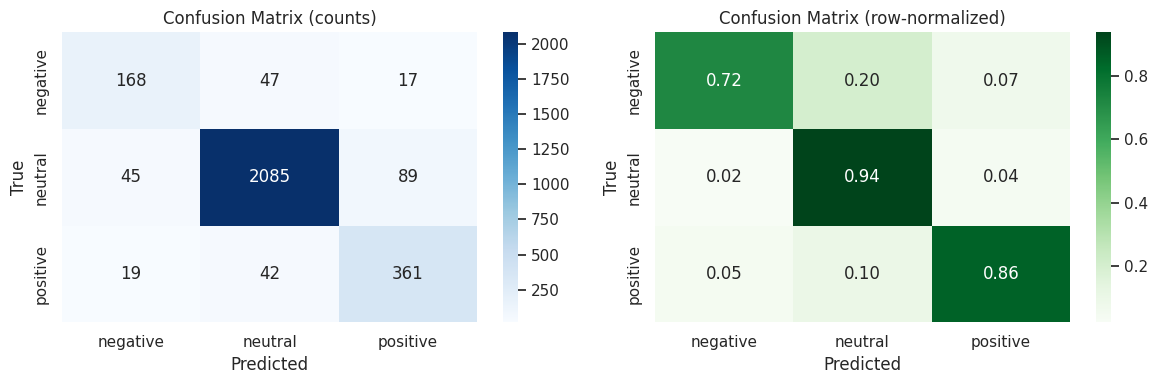

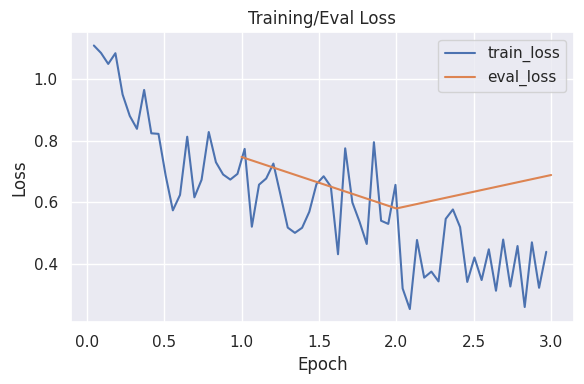

Saved to: /content/xlmr_es_sentiment_best


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {"accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1}

OUTPUT_DIR = "/content/xlmr_es_sentiment"

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",
    fp16=USE_FP16,
    bf16=USE_BF16,
)

trainer = WeightedCELossTrainer(
    class_weights=class_weights,
    model=model,
    args=args,
    train_dataset=tok["train"],
    eval_dataset=tok["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

eval_res = trainer.evaluate()
print(json.dumps(eval_res, indent=2))

preds = trainer.predict(tok["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)]))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)])
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens", ax=ax[1],
            xticklabels=[id2label[i] for i in range(num_labels)],
            yticklabels=[id2label[i] for i in range(num_labels)])
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
plt.tight_layout(); plt.show()

logs = trainer.state.log_history
loss_pts = [(e.get("epoch"), e.get("loss")) for e in logs if "loss" in e]
eval_pts = [(e.get("epoch"), e.get("eval_loss")) for e in logs if "eval_loss" in e]

plt.figure(figsize=(6,4))
if loss_pts:
    xs, ys = zip(*loss_pts); plt.plot(xs, ys, label="train_loss")
if eval_pts:
    xs2, ys2 = zip(*eval_pts); plt.plot(xs2, ys2, label="eval_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training/Eval Loss")
plt.legend(); plt.tight_layout(); plt.show()

save_dir = "/content/xlmr_es_sentiment_best"
trainer.model.save_pretrained(save_dir)
trainer.tokenizer.save_pretrained(save_dir)
with open(f"{save_dir}/label2id.json","w",encoding="utf-8") as f: json.dump(label2id,f,ensure_ascii=False,indent=2)
with open(f"{save_dir}/id2label.json","w",encoding="utf-8") as f: json.dump(id2label,f,ensure_ascii=False,indent=2)
print("Saved to:", save_dir)